In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

# # Font update global for all plots
# plt.rcParams.update({"font.size": 18})

In [2]:
# Import dataset
data = np.loadtxt(open("../Datasets/mnist_train_small.csv", "rb"), delimiter=",")

# Extract data and labels
labels = data[:, 0]
data = data[:, 1:]

# Normalize the data
dataNorm = data / np.max(data)

In [3]:
# Step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Step 2: Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labelsT, test_size=0.1
)

# Step 3: Convert to pytorch dataset
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Step 4: Translate into dataloader objects
batchSize = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batchSize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device=device),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset.tensors[0].shape[0],
    generator=torch.Generator(device=device),
)

In [4]:
# Model class function
def createTheModel():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden layers
            self.hidden1 = nn.Linear(64, 32)
            self.hidden2 = nn.Linear(32, 32)

            # Output layer
            self.output = nn.Linear(32, 10)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            x = self.output(x)
            return x

    # Instansiate the model
    net = mnistNet()

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, lossFun, optimizer

In [5]:
tmpnet = createTheModel()[0]
print(tmpnet)

print("\n\nWeights for layer fc1:")
print(tmpnet.hidden1.weight.data)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (hidden1): Linear(in_features=64, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[-0.0376, -0.1053, -0.0654,  ...,  0.0508, -0.0644,  0.1129],
        [-0.0635, -0.1029,  0.0059,  ..., -0.0394, -0.0836, -0.1111],
        [ 0.1052,  0.0319, -0.0680,  ..., -0.0037,  0.0550,  0.0152],
        ...,
        [ 0.0746, -0.0299,  0.0282,  ..., -0.0174,  0.1238, -0.0688],
        [ 0.0477, -0.0835,  0.0554,  ..., -0.0982, -0.0383, -0.1046],
        [-0.0036,  0.0213,  0.0902,  ..., -0.0779,  0.0022, -0.0027]],
       device='cuda:0')


In [6]:
# Function to train the model
def trainTheModel(net, lossFun, optimizer, nEpochs):
    # initialize loss and accuracies
    losses = torch.zeros(nEpochs)
    trainAcc = []
    testAcc = []

    # Loop over epochs
    for epoch in range(nEpochs):
        # Put model in trainig model
        net.train()

        # Loop over training data batches
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss for this batch
            batchLoss.append(loss.cpu().item())

            # Compute Accuracy
            batchAcc.append(
                (100 * torch.mean((torch.argmax(yHat, axis=1) == y).float())).cpu()
            )
        # Batch Loop end
        # Train acc and losses
        trainAcc.append(np.mean(batchAcc))
        losses[epoch] = np.mean(batchLoss)

        # Test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append(
            (100 * torch.mean((torch.argmax(yHat, axis=1) == y).float())).cpu()
        )
    # Function output
    return trainAcc, testAcc, losses, net

In [10]:
# The Experiment
# Range of std dev to use
stdDevs = np.logspace(np.log10(0.0001), np.log10(10), 25)

# Number of histogram bins for plotting distributions
nHistBins = 80

# Initialize results output matrix
accResults = np.zeros(len(stdDevs))
hisToData = np.zeros((len(stdDevs), 2, nHistBins))

# Start the timer
startTime = time.process_time()

# Now to really start the expriment
for idx, std in enumerate(stdDevs):
    # Create the network
    net, lossFun, optimizer = createTheModel()

    # Set all the parameters according to std dev
    for p in net.named_parameters():
        p[1].data = torch.randn_like(p[1].data) * std
    
    # Train the model
    trainAcc, testAcc, losses, net = trainTheModel(net, lossFun, optimizer, nEpochs=10)

    # Get the test the accuracy on the final 3 runs
    accResults[idx] = np.mean(testAcc[-3:])

    # Collect all parameters into one vector and compute its histogram
    tmpParams = np.array([])
    for p in net.named_parameters():
        tmpParams = np.concatenate((tmpParams, p[1].data.cpu().numpy().flatten()), axis=0)
    
    # Now compute their histogram
    y, x = np.histogram(tmpParams, nHistBins)
    hisToData[idx, 0, :] = (x[1:] + x[:-1]) / 2
    hisToData[idx, 1, :] = y

    # Status Report
    timeElapsed = time.process_time() - startTime
    print(f'Finished {idx+1}/{len(stdDevs)} after {timeElapsed:3.0f}s. Model accuracy was {accResults[idx]:.2f}%.')

Finished 1/25 after  16s. Model accuracy was 12.10%.
Finished 2/25 after  31s. Model accuracy was 93.30%.
Finished 3/25 after  46s. Model accuracy was 93.77%.
Finished 4/25 after  62s. Model accuracy was 94.38%.
Finished 5/25 after  77s. Model accuracy was 92.13%.
Finished 6/25 after  92s. Model accuracy was 92.78%.
Finished 7/25 after 107s. Model accuracy was 94.08%.
Finished 8/25 after 123s. Model accuracy was 93.87%.
Finished 9/25 after 138s. Model accuracy was 93.50%.
Finished 10/25 after 153s. Model accuracy was 94.27%.
Finished 11/25 after 169s. Model accuracy was 94.73%.
Finished 12/25 after 184s. Model accuracy was 94.87%.
Finished 13/25 after 199s. Model accuracy was 94.42%.
Finished 14/25 after 214s. Model accuracy was 95.53%.
Finished 15/25 after 229s. Model accuracy was 94.90%.
Finished 16/25 after 244s. Model accuracy was 94.73%.
Finished 17/25 after 258s. Model accuracy was 94.88%.
Finished 18/25 after 273s. Model accuracy was 95.07%.
Finished 19/25 after 288s. Model accu

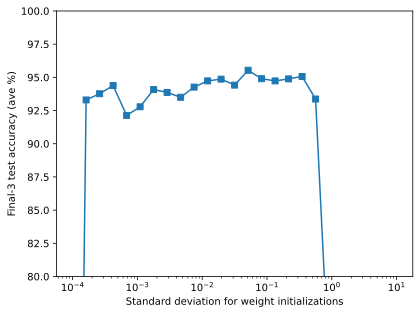

In [11]:
# Show the results!
plt.plot(stdDevs, accResults, "s-")
plt.xlabel("Standard deviation for weight initializations")
plt.ylabel("Final-3 test accuracy (ave %)")
plt.xscale("log")
plt.ylim([80, 100])
plt.show()

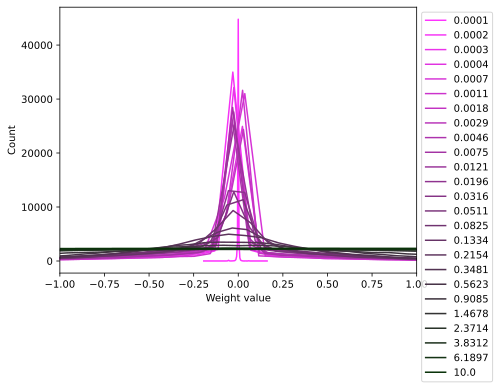

In [13]:
# show the weights distributions

for i in range(len(stdDevs)):
    plt.plot(
        hisToData[i, 0, :],
        hisToData[i, 1, :],
        color=[1 - i / len(stdDevs), 0.2, 1 - i / len(stdDevs)],
    )

plt.xlabel("Weight value")
plt.ylabel("Count")
plt.legend(np.round(stdDevs, 4), bbox_to_anchor=(1, 1), loc="upper left")
plt.xlim([-1,1])
plt.show()